In [ ]:
#imports
!pip install numpy astropy matplotlib scipy sunpy[all]
!pip install sunkit-image
!pip install aiapy
from astropy import units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from sunpy.map import Map
from sunpy.net.jsoc import JSOCClient, attrs as jsoc
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, AsinhStretch
from sunpy.visualization.colormaps import cm
from matplotlib.patches import Rectangle
from reproject import reproject_interp
import matplotlib
from IPython.display import HTML
from sunkit_image import trace
from aiapy.calibrate import register, update_pointing
from aiapy.calibrate.util import get_pointing_table
from matplotlib.patches import Polygon
from glob import glob
from scipy.interpolate import CubicSpline
import matplotlib.animation as animation
import matplotlib.patches as patches

# JSOC Client
JSOC = JSOCClient()

In [ ]:
JSOC = JSOCClient()

# Define the time window and wavelength set
time = jsoc.Time("2016-06-16T07:19:17", "2016-06-16T07:19:18")
wavelengths = [1700, 171, 94, 304, 1600, 193] * u.angstrom

maps = []

for wl in wavelengths:
    series = "aia.lev1_uv_24s" if wl.value in [1600, 1700] else "aia.lev1_euv_12s"
    result = JSOC.search(
        time,
        jsoc.Series(series),
        jsoc.Wavelength(wl),
        jsoc.Segment("image"),
        jsoc.Notify("yadav23@iiserb.ac.in")
    )

    # Check if any file was returned
    if not result:
        print(f" No result for {wl}")
        continue

    files = JSOC.fetch(result)
    m = sunpy.map.Map(files[0])
    m = register(m)  # AIA correction
    maps.append(m)

# Unpack into individual variables just like Fido-based routine
aia_1700, aia_171, aia_94, aia_304, aia_1600, aia_193 = maps

INFO:sunpy:1 URLs found for download. Full request totaling 12MB


INFO: 1 URLs found for download. Full request totaling 12MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

INFO:sunpy:1 URLs found for download. Full request totaling 11MB


INFO: 1 URLs found for download. Full request totaling 11MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

INFO:sunpy:1 URLs found for download. Full request totaling 6MB


INFO: 1 URLs found for download. Full request totaling 6MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

INFO:sunpy:1 URLs found for download. Full request totaling 7MB


INFO: 1 URLs found for download. Full request totaling 7MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

INFO:sunpy:1 URLs found for download. Full request totaling 9MB


INFO: 1 URLs found for download. Full request totaling 9MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

INFO:sunpy:1 URLs found for download. Full request totaling 11MB


INFO: 1 URLs found for download. Full request totaling 11MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

INFO:sunpy:1 URLs found for download. Full request totaling 15MB


INFO: 1 URLs found for download. Full request totaling 15MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

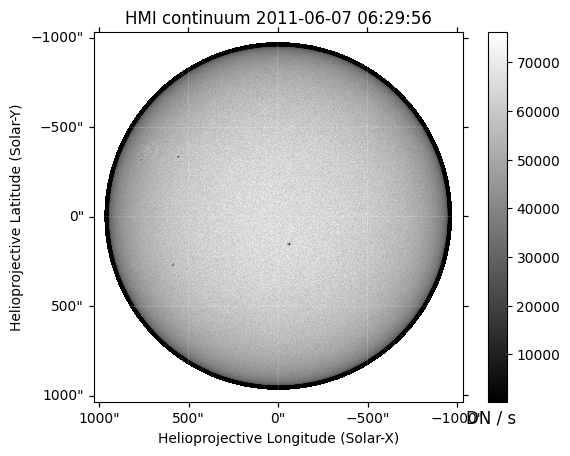

In [ ]:
result_hmi = JSOC.search(
    jsoc.Time("2011-06-07T06:30:00", "2011-06-07T06:30:01"),
    jsoc.Series("hmi.Ic_45s"),
    jsoc.Segment("continuum"),
    jsoc.Notify("yadav23@iiserb.ac.in")
)

if result_hmi:
    downloaded_hmi = JSOC.fetch(result_hmi)
    hmi_map = Map(downloaded_hmi[0])
    hmi_map.peek()
else:
    print(" No HMI result found.")


In [ ]:
top_right = SkyCoord(6*u.arcsec, -95*u.arcsec, frame=aia_1700.coordinate_frame)
bottom_left = SkyCoord(-52 * u.arcsec, -165. * u.arcsec, frame=aia_1700.coordinate_frame)


INFO:sunpy:Using image-based autoalignment


INFO: Using image-based autoalignment [sunpy.map.mapbase]


INFO:sunpy:Using image-based autoalignment


INFO: Using image-based autoalignment [sunpy.map.mapbase]


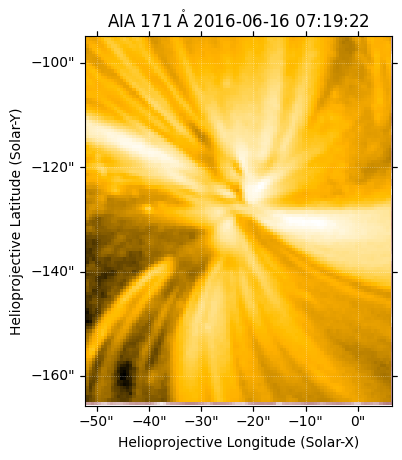

In [ ]:
aia1700_sub = aia_1700.submap(bottom_left=bottom_left, top_right=top_right)
aia1700_sub.plot()

aia304_sub = aia_304.submap(bottom_left=bottom_left, top_right=top_right)
aia304_sub.plot()

aia171_sub = aia_171.submap(bottom_left=bottom_left, top_right=top_right)
aia171_sub.plot()

In [ ]:
aia1700_sub = aia_1700.submap(bottom_left=bottom_left, top_right=top_right)
aia171_sub  = aia_171.submap(bottom_left=bottom_left, top_right=top_right)
aia94_sub   = aia_94.submap(bottom_left=bottom_left, top_right=top_right)
aia304_sub  = aia_304.submap(bottom_left=bottom_left, top_right=top_right)
aia1600_sub = aia_1600.submap(bottom_left=bottom_left, top_right=top_right)
aia193_sub  = aia_193.submap(bottom_left=bottom_left, top_right=top_right)

In [ ]:
from matplotlib import pyplot as plt
from astropy.visualization import ImageNormalize, AsinhStretch
import matplotlib.cm as cm

# Optional: Set a common threshold level for contours
contour_multiplier = 2.0  # mean + 2σ

# AIA color maps
cmap_dict = {
    "1700 Å": cm.sdoaia1700,
    "1600 Å": cm.sdoaia1600,
    "171 Å": cm.sdoaia171,
    "193 Å": cm.sdoaia193,
    "304 Å": cm.sdoaia304,
    "94 Å": cm.sdoaia94
}

# Loop through each submap and plot contours
for title, smap in submaps.items():
    data = smap.data
    threshold = data.mean() + contour_multiplier * data.std()

    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection=smap)

    # Display image using correct colormap
    norm = ImageNormalize(stretch=AsinhStretch())
    im = ax.imshow(data, cmap=cmap_dict.get(title, 'gray'), origin='lower', norm=norm)

    # Plot contour directly from data array
    ax.contour(data, levels=[threshold], colors='red', linewidths=1.2)

    # Axes formatting
    ax.set_xlabel('Solar X [arcsec]')
    ax.set_ylabel('Solar Y [arcsec]')
    plt.title(f"AIA {title} with Contour")

    # Colorbar
    plt.colorbar(im, ax=ax, label=f'Intensity [{smap.unit}]')

    # show
    plt.savefig(f"aia_{title.replace(' ', '').replace('Å', '')}_with_contour.png", dpi=300, bbox_inches='tight')
    plt.show()


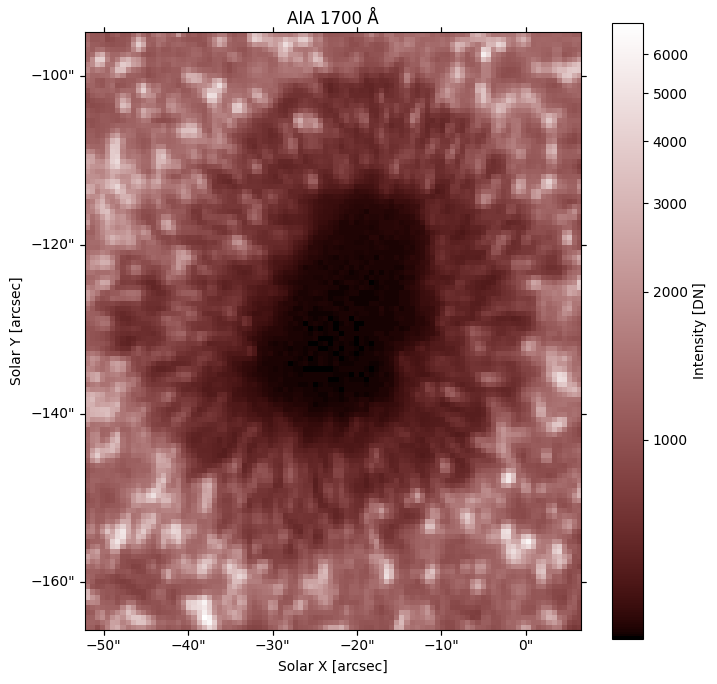

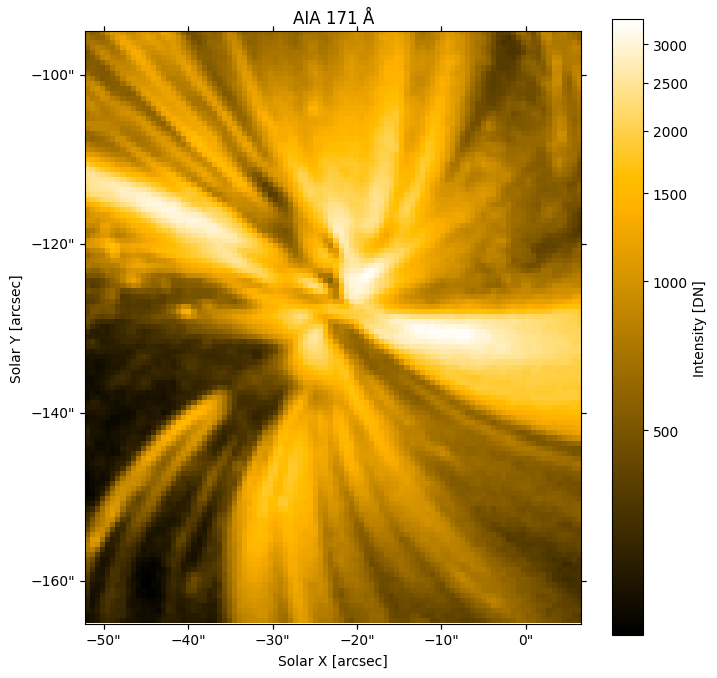

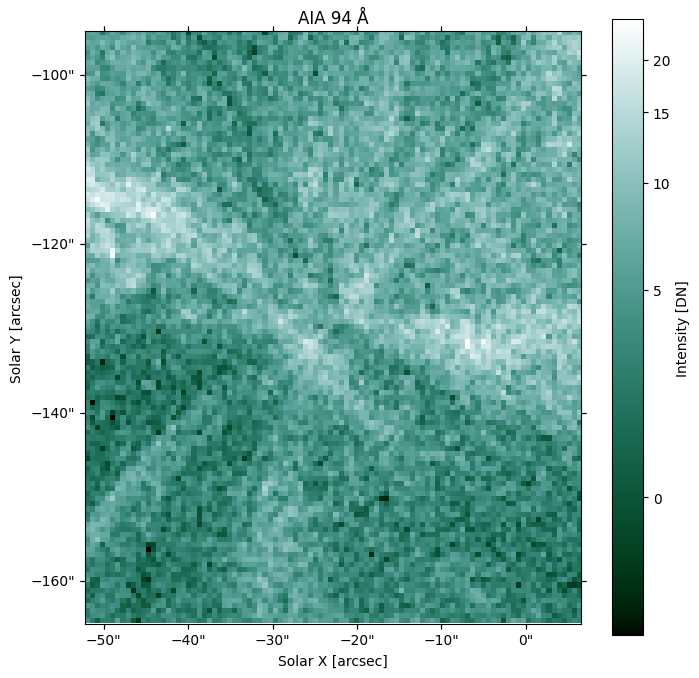

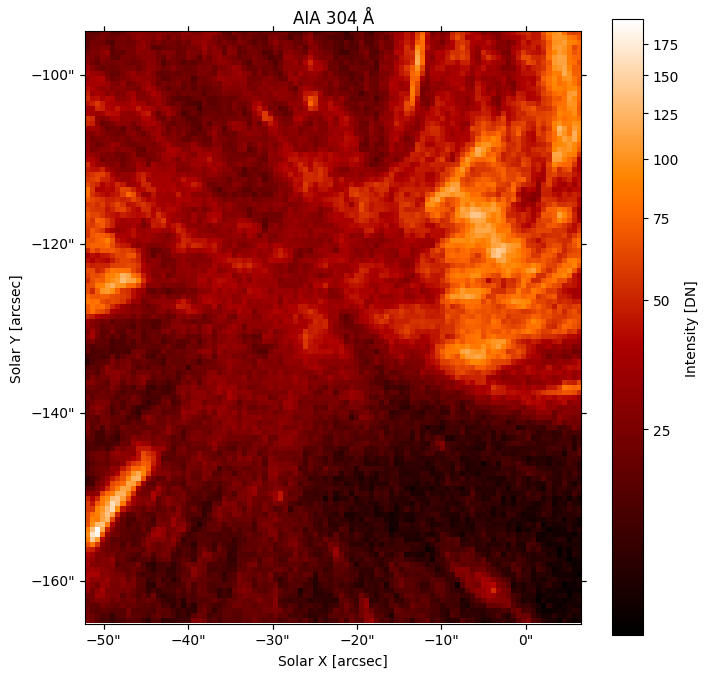

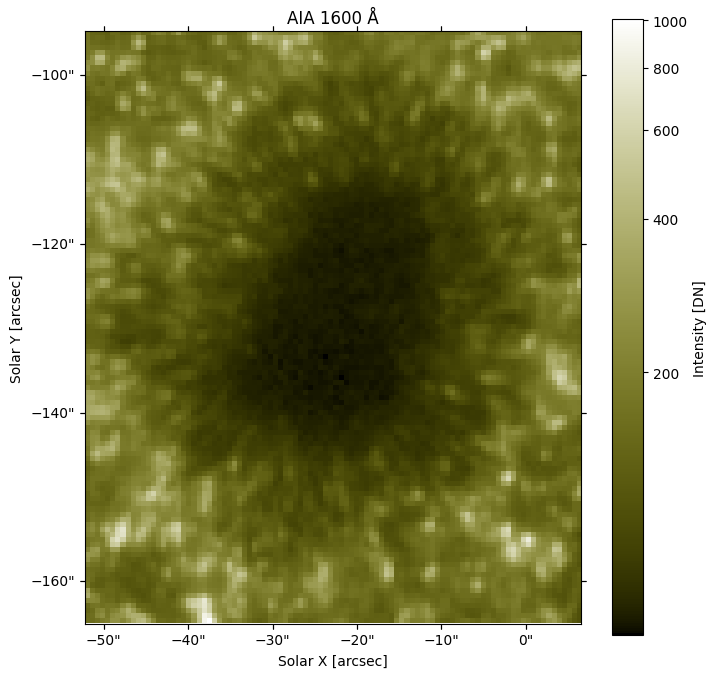

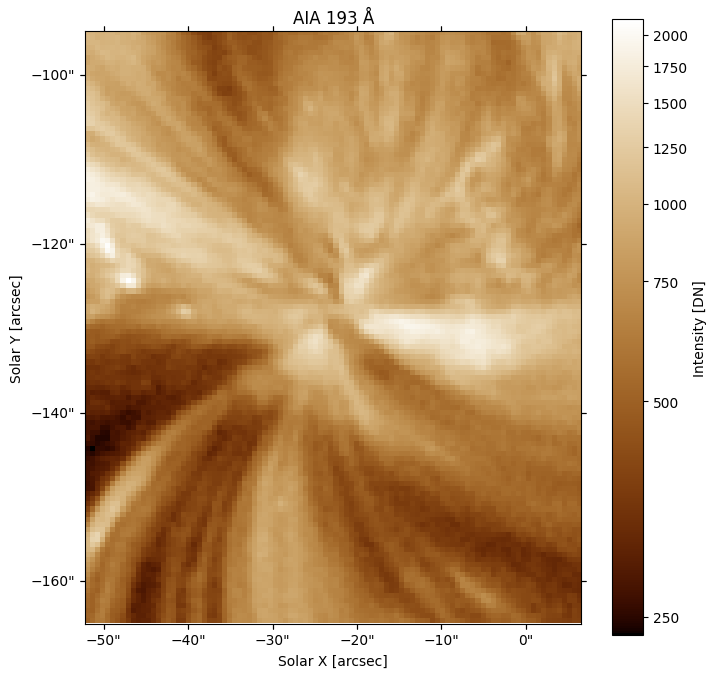

In [ ]:
from matplotlib import pyplot as plt
from astropy.visualization import ImageNormalize, AsinhStretch
# import matplotlib.cm as cm # Removed

import sunpy.visualization.colormaps as sunpy_cm

# Use the cmlist dictionary to access SunPy AIA colormaps
cmap_dict = {
    "1700 Å": sunpy_cm.cmlist['sdoaia1700'],
    "1600 Å": sunpy_cm.cmlist['sdoaia1600'],
    "171 Å":  sunpy_cm.cmlist['sdoaia171'],
    "193 Å":  sunpy_cm.cmlist['sdoaia193'],
    "94 Å":   sunpy_cm.cmlist['sdoaia94'],
    "304 Å":  sunpy_cm.cmlist['sdoaia304']
}



# Define the submaps dictionary
    "1700 Å": aia1700_sub,
    "171 Å": aia171_sub,
    "94 Å": aia94_sub,
    "304 Å": aia304_sub,
    "1600 Å": aia1600_sub,
    "193 Å": aia193_sub
}


# Plot submaps without contours
for title, smap in submaps.items():
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection=smap.wcs)

    # Normalize and plot image
    norm = ImageNormalize(stretch=AsinhStretch())
    im = ax.imshow(smap.data, cmap=cmap_dict.get(title, 'gray'), origin='lower', norm=norm)

    # Axis labels and title
    ax.set_xlabel('Solar X [arcsec]')
    ax.set_ylabel('Solar Y [arcsec]')
    ax.set_title(f'AIA {title}')

    # Colorbar
    plt.colorbar(im, ax=ax, label=f'Intensity [{smap.unit}]')

    # Save and show
    plt.savefig(f"AIA_{title.replace(' ', '').replace('Å', '')}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# Load and register HMI continuum map
hmi_ic = Map(JSOC.fetch(JSOC.search(
    jsoc.Time("2016-06-16T07:19:17", "2016-06-16T07:19:18"),
    jsoc.Series("hmi.Ic_45s"),
    jsoc.Segment("continuum"),
    jsoc.Notify("yadav23@iiserb.ac.in")
))[0])

hmi_ic = register(hmi_ic)
hmi_ic_sub = hmi_ic.submap(bottom_left=bottom_left, top_right=top_right)

# Reproject HMI submap to match AIA WCS
reference_aia = aia171_sub
hmi_reproj_data, _ = reproject_interp((hmi_ic_sub.data, hmi_ic_sub.wcs),
                                      reference_aia.wcs,
                                      shape_out=reference_aia.data.shape)

# Umbra contour threshold
umbra_threshold = 22000


INFO:sunpy:1 URLs found for download. Full request totaling 15MB


INFO: 1 URLs found for download. Full request totaling 15MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

hmi.ic_45s.20160616_072015_TAI.2.continuum.fits:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

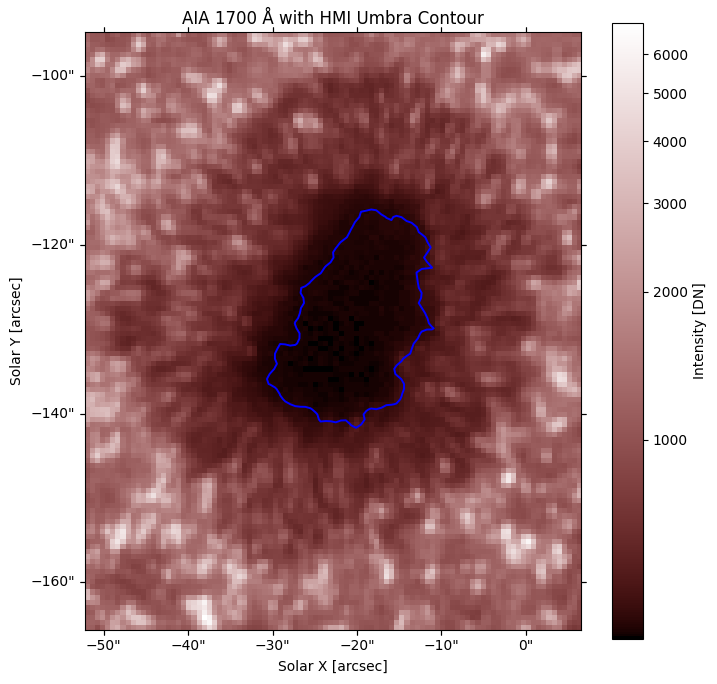

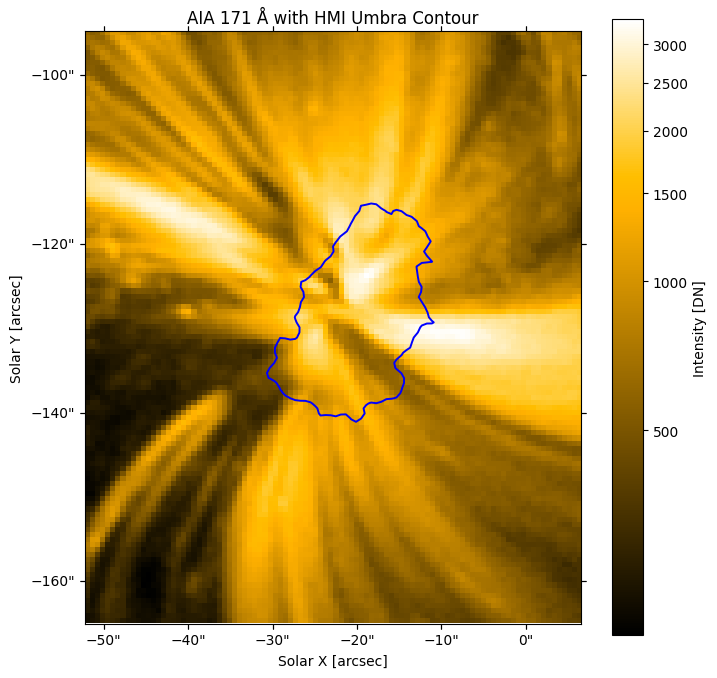

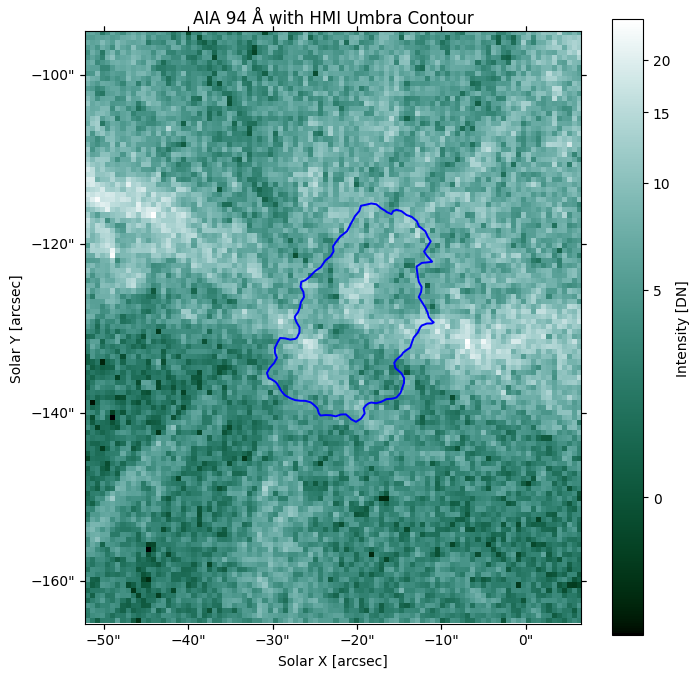

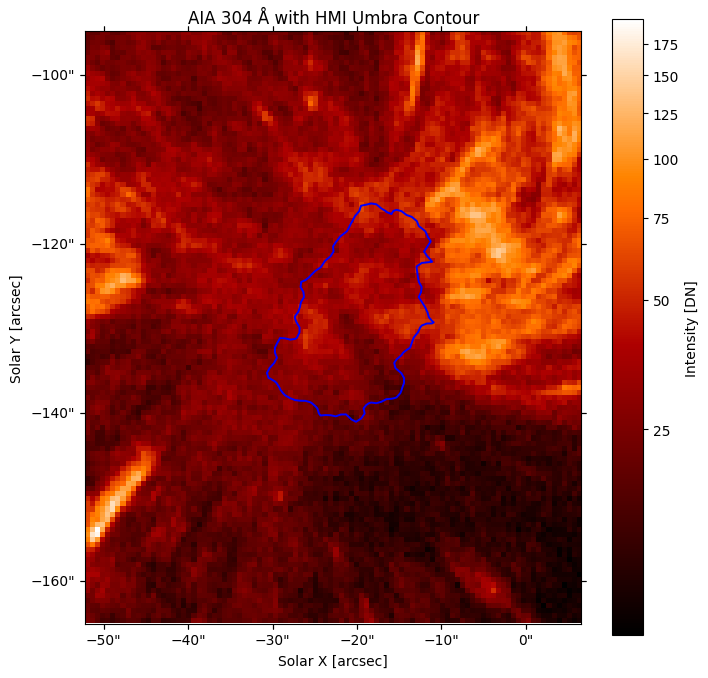

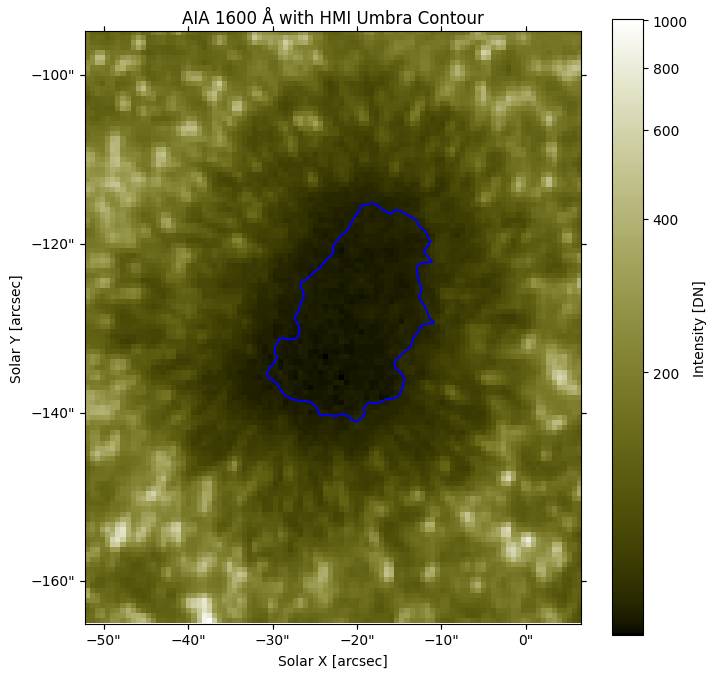

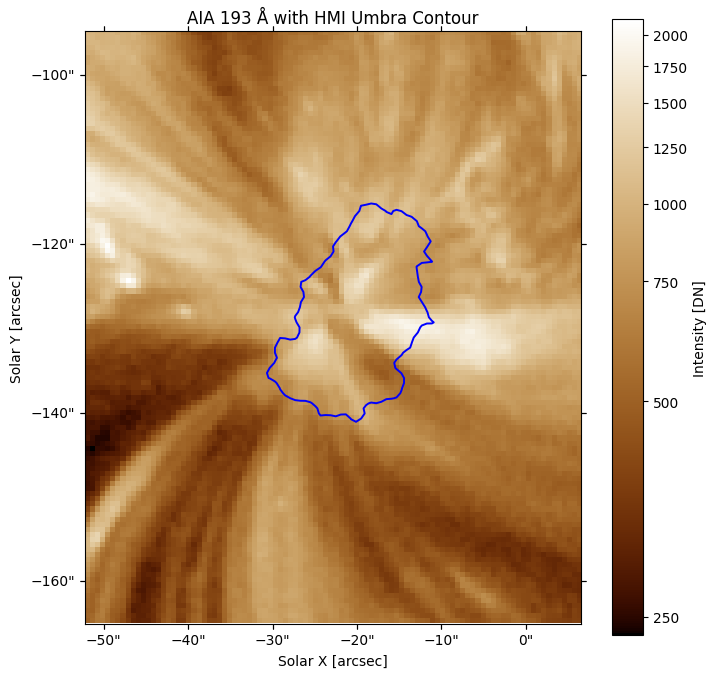

In [ ]:
for title, smap in submaps.items():
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection=smap.wcs)

    # Plot AIA submap
    norm = ImageNormalize(stretch=AsinhStretch())
    im = ax.imshow(smap.data, cmap=cmap_dict.get(title, 'gray'), origin='lower', norm=norm)

    # Overlay HMI umbra contour
    ax.contour(hmi_reproj_data, levels=[umbra_threshold], colors='blue', linewidths=1.4)

    # Labels and formatting
    ax.set_xlabel('Solar X [arcsec]')
    ax.set_ylabel('Solar Y [arcsec]')
    ax.set_title(f'AIA {title} with HMI Umbra Contour')
    plt.colorbar(im, ax=ax, label=f'Intensity [{smap.unit}]')

    # Save and show
    plt.savefig(f"AIA_{title.replace(' ', '').replace('Å', '')}_umbra.png", dpi=300, bbox_inches='tight')
    plt.show()


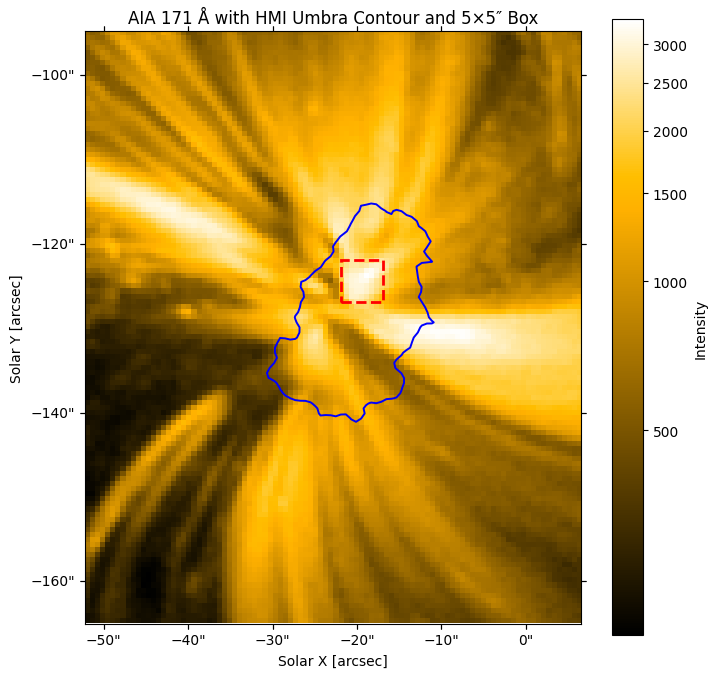

In [ ]:
import matplotlib.patches as patches
from astropy.visualization import ImageNormalize, AsinhStretch
import matplotlib.pyplot as plt
import matplotlib.cm as cm

cmap = sunpy_cm.cmlist['sdoaia171']

# Define box size in arcseconds and pixel scale
box_size_arcsec = 5
pixel_scale = 0.6  # AIA resolution ≈ 0.6 arcsec/pixel
box_size_pixels = box_size_arcsec / pixel_scale  # ~8.33 pixels

# Define starting pixel location for box )
x_start, y_start = 50, 63

# Plot AIA 171 Å submap with HMI umbra contour and red box
plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=aia171_sub.wcs)

# Plot image with sdoaia171 colormap
norm = ImageNormalize(stretch=AsinhStretch())
im = ax.imshow(aia171_sub.data, cmap = sunpy_cm.cmlist['sdoaia171']
, origin='lower', norm=norm)

# Plot HMI umbra contour
ax.contour(hmi_reproj_data, levels=[umbra_threshold], colors='blue', linewidths=1.4)

# Add 5×5 arcsec box (≈8.33×8.33 px)
rect = patches.Rectangle(
    (x_start, y_start), box_size_pixels, box_size_pixels,
    linewidth=2, edgecolor='red', facecolor='none', linestyle='--'
)
ax.add_patch(rect)

# Add labels, colorbar, and title
ax.set_xlabel('Solar X [arcsec]')
ax.set_ylabel('Solar Y [arcsec]')
plt.colorbar(im, ax=ax, label='Intensity')
plt.title('AIA 171 Å with HMI Umbra Contour and 5×5″ Box')

# Save and display
plt.savefig('aia171_with_box.png', dpi=300, bbox_inches='tight')
plt.show()


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

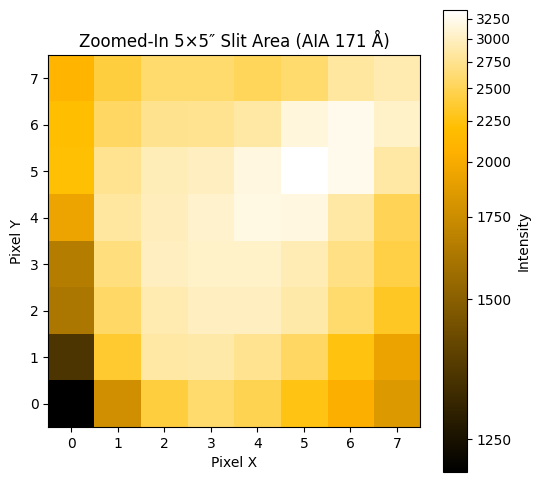

In [ ]:
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, AsinhStretch
import sunpy.visualization.colormaps as sunpy_cm

# Box setup
x_start, y_start = 50, 63
box_size_arcsec = 5
pixel_scale = 0.6
box_size_pixels = int(box_size_arcsec / pixel_scale)

x_end = int(x_start + box_size_pixels)
y_end = int(y_start + box_size_pixels)

# Ensure bounds are within aia171_sub
x_end = min(x_end, aia171_sub.data.shape[1])
y_end = min(y_end, aia171_sub.data.shape[0])

# Extract the slit area
box_area = aia171_sub.data[y_start:y_end, x_start:x_end]

# Plot the extracted 5×5 arcsec box
plt.figure(figsize=(6, 6))
norm = ImageNormalize(stretch=AsinhStretch())
cmap = sunpy_cm.cmlist['sdoaia171']

plt.imshow(box_area, cmap=cmap, origin='lower', norm=norm)
plt.colorbar(label='Intensity')
plt.title('Zoomed-In 5×5″ Slit Area (AIA 171 Å)')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt


In [ ]:
# Load all 1600 Å files
aia_series = {
    1600: sorted(glob('./data/aia*1600*.fits'))  # Adjust path if needed
}


In [ ]:
# Times from Sharma et al. (2017)
flash_times = [
    "2010-12-11T09:46:41",
    "2010-12-11T09:49:05",
    "2010-12-11T09:51:55",
    "2010-12-11T09:54:41",
    "2010-12-11T09:57:05"
]


In [ ]:
def find_closest_map(target_time, file_list):
    target = parse_time(target_time)
    min_dt = np.inf
    closest = None
    for f in file_list:
        m = Map(f)
        dt = abs(parse_time(m.date) - target)
        if dt < min_dt:
            min_dt = dt
            closest = f
    return closest


In [ ]:
# Confirmed slit box inside submap (from earlier Figure 1 analysis)
x_start, y_start = 50, 63
pixel_scale = 0.6
box_size_arcsec = 5
box_size_pixels = int(box_size_arcsec / pixel_scale)


In [ ]:
# Set your email (required by JSOC)
email = "yadav23@iiserb.ac.in"

# Flash times from paper
flash_times = [
    "2010-12-11T09:46:41",
    "2010-12-11T09:49:05",
    "2010-12-11T09:51:55",
    "2010-12-11T09:54:41",
    "2010-12-11T09:57:05"
]

client = JSOCClient()
downloaded_files = []

for t in flash_times:
    t_start = parse_time(t) - 30*u.s
    t_end = parse_time(t) + 30*u.s
    result = client.search(
        jsoc.Time(t_start, t_end),
        jsoc.Series("aia.lev1_uv_24s"),
        jsoc.Wavelength(1600*u.angstrom),
        jsoc.Segment("image"),
        jsoc.Notify(email)
    )
    if result:
        files = client.fetch(result)
        downloaded_files.extend(files)

# Print the downloaded paths
print("Downloaded files:")
for f in downloaded_files:
    print(f)

INFO:sunpy:3 URLs found for download. Full request totaling 31MB


INFO: 3 URLs found for download. Full request totaling 31MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

aia.lev1_uv_24s.2010-12-11T094619Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

aia.lev1_uv_24s.2010-12-11T094643Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

aia.lev1_uv_24s.2010-12-11T094707Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

Exception ignored in: <function BaseEventLoop.__del__ at 0x7ec13608ee80>
Traceback (most recent call last):
  File "/usr/lib/python3.11/asyncio/base_events.py", line 695, in __del__
    self.close()
  File "/usr/lib/python3.11/asyncio/unix_events.py", line 71, in close
    self.remove_signal_handler(sig)
  File "/usr/lib/python3.11/asyncio/unix_events.py", line 160, in remove_signal_handler
    signal.signal(sig, handler)
  File "/usr/lib/python3.11/signal.py", line 58, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: signal only works in main thread of the main interpreter
INFO:sunpy:3 URLs found for download. Full request totaling 31MB


INFO: 3 URLs found for download. Full request totaling 31MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

aia.lev1_uv_24s.2010-12-11T094843Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

aia.lev1_uv_24s.2010-12-11T094907Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

aia.lev1_uv_24s.2010-12-11T094931Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

INFO:sunpy:3 URLs found for download. Full request totaling 31MB


INFO: 3 URLs found for download. Full request totaling 31MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

aia.lev1_uv_24s.2010-12-11T095131Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

aia.lev1_uv_24s.2010-12-11T095155Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

aia.lev1_uv_24s.2010-12-11T095219Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

INFO:sunpy:3 URLs found for download. Full request totaling 31MB


INFO: 3 URLs found for download. Full request totaling 31MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

aia.lev1_uv_24s.2010-12-11T095419Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

aia.lev1_uv_24s.2010-12-11T095443Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

aia.lev1_uv_24s.2010-12-11T095507Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

INFO:sunpy:3 URLs found for download. Full request totaling 31MB


INFO: 3 URLs found for download. Full request totaling 31MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

aia.lev1_uv_24s.2010-12-11T095643Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

aia.lev1_uv_24s.2010-12-11T095707Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

aia.lev1_uv_24s.2010-12-11T095731Z.1600.image_lev1.fits:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

Downloaded files:
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T094619Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T094643Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T094707Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T094843Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T094907Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T094931Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T095131Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T095155Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T095219Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T095419Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T095443Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T095507Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T095643Z.1600.image_lev1.fits
/root/sunpy/data/aia.lev1_uv_24s.

In [ ]:
from pathlib import Path

downloads_dir = Path.home() / "Downloads"
files_1600 = list(downloads_dir.glob("aia*1600*.fits"))

aia_series = {
    1600: sorted([str(f) for f in files_1600])
}



In [ ]:
flash_times = [
    "2010-12-11T09:46:41",
    "2010-12-11T09:49:05",
    "2010-12-11T09:51:55",
    "2010-12-11T09:54:41",
    "2010-12-11T09:57:05"
]
x_start, y_start = 50, 63   # Confirmed box pixel coords from earlier
pixel_scale = 0.6           # AIA plate scale
box_size_arcsec = 5
box_size_pixels = int(box_size_arcsec / pixel_scale)


In [ ]:
for file in aia_series[1600]:
    try:
        m = register(Map(file))
        print(f"{file}: shape={m.data.shape}, min={np.nanmin(m.data)}, max={np.nanmax(m.data)}")
    except Exception as e:
        print(f"{file} failed: {e}")


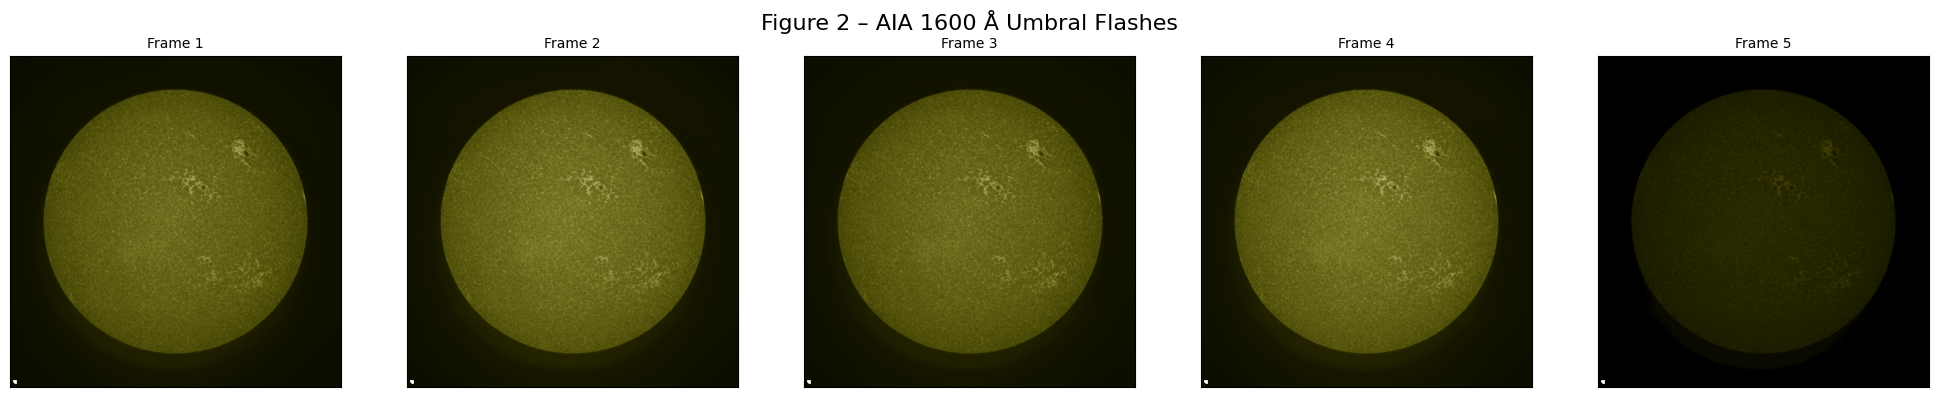

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sunpy.map import Map
from aiapy.calibrate import register
from sunpy.visualization.colormaps import cmlist as sunpy_cm
from astropy.visualization import ImageNormalize, AsinhStretch

# Files you downloaded from JSOC
aia_series = {
    1600: sorted([
        '/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T094619Z.1600.image_lev1.fits',
        '/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T094643Z.1600.image_lev1.fits',
        '/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T094707Z.1600.image_lev1.fits',
        '/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T094843Z.1600.image_lev1.fits',
        '/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T094907Z.1600.image_lev1.fits'
    ])
}

# Umbral flash box details
x_start, y_start = 50, 63
pixel_scale = 0.6  # arcsec/pixel
box_size_arcsec = 5
box_size_pixels = int(box_size_arcsec / pixel_scale)

# SunPy colormap for AIA 1600 Å
cmap = sunpy_cm['sdoaia1600']

# Plot the 5 flashes side-by-side
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, file in enumerate(aia_series[1600]):
    m = register(Map(file))
    norm = ImageNormalize(stretch=AsinhStretch())
    ax = axes[i]
    im = ax.imshow(m.data, cmap=cmap, origin='lower', norm=norm)

    # Draw white 5×5 arcsec box
    rect = patches.Rectangle(
        (x_start, y_start), box_size_pixels, box_size_pixels,
        linewidth=2, edgecolor='white', facecolor='none', linestyle='--'
    )
    ax.add_patch(rect)

    # Clean up axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Frame {i+1}", fontsize=10)

plt.suptitle("Figure 2 – AIA 1600 Å Umbral Flashes", fontsize=16)
plt.tight_layout()
plt.savefig("figure2_umbral_flashes_1600A.png", dpi=300)
plt.show()


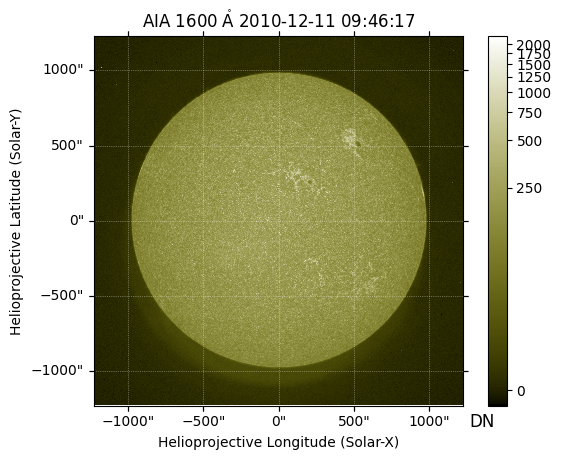

In [ ]:
m = register(Map('/root/sunpy/data/aia.lev1_uv_24s.2010-12-11T094619Z.1600.image_lev1.fits'))
m.peek()


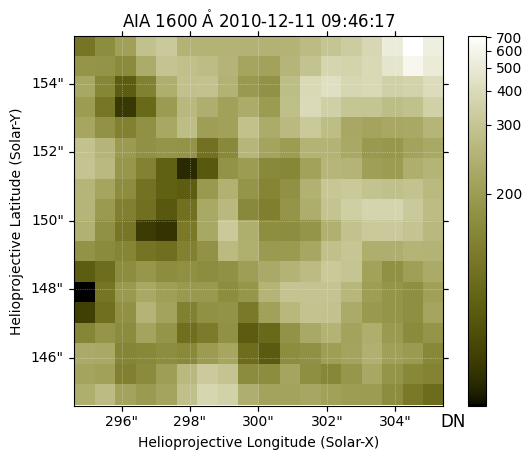

In [ ]:

center = SkyCoord(300*u.arcsec, 150*u.arcsec, frame=m.coordinate_frame)
width = height = 10 * u.arcsec


bottom_left = SkyCoord(center.Tx - width/2, center.Ty - height/2, frame=m.coordinate_frame)
top_right = SkyCoord(center.Tx + width/2, center.Ty + height/2, frame=m.coordinate_frame)

zoomed_map = m.submap(bottom_left=bottom_left, top_right=top_right)

zoomed_map.peek(cmap='sdoaia1600')